## Simple test with IBTrACS

We select time series of a certain number of parameters of interest from IBTrACS (say n = 8 parameters). The goal is to make an accurate prediction of these n parameters using time series of IBTrACS that would be available only in low resolution observations (that is, without Vmax, Rmax, R64 and R50).

Either consider North Atlantic basin only (IBTrACS.NA.v04r00.nc) or all basins (IBTrACS.ALL.v04r00.nc)


In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils as du
import pytorchUtils as pu

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### PARAMS
PARAMS = {'seq_len':          4, # length of the input time series used to predict y(t)
          'save_figs':        False,
          'feature_scaling':  True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Models
    'lstm_path':    '/home/arthur/results/TCsLifeMonitFromObs/lstm_dynamic_pred_ibtracs/lstm.pth', 
    # Save
    
}

### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'nature']

In [3]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
ds_ibt_raw

<xarray.Dataset>
Dimensions:           (storm: 2293, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 ...
    sid               (storm) |S13 ...
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [4]:
### FILTERS
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# By latitude
ds_ibt     = ds_ibt.where(np.abs(ds_ibt['lat']) <= 30)
# By removing empty Rmax time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_rmw'].notnull().sum(axis=1) > 5)
# By removing empty R34 time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_r34'].notnull().sum(axis=1) > 5) 
# By agency
if os.path.basename(PATHS['ibtracs_data']) == 'IBTrACS.NA.v04r00.nc': ds_ibt     = ds_ibt.where(ds_ibt['usa_agency'] == b'hurdat_atl')

# ==> Drop NaNs
ds_ibt     = ds_ibt.dropna(dim='storm', how='all') # Much quicker to drop NaNs only at the end

In [5]:
ds_ibt

<xarray.Dataset>
Dimensions:     (storm: 236, date_time: 360, quadrant: 4)
Coordinates:
    time        (storm, date_time) datetime64[ns] 2001-08-02T12:00:00.0000404...
    lat         (storm, date_time) float32 25.7 25.98 26.2 26.32 ... nan nan nan
    lon         (storm, date_time) float32 -84.8 -84.79 -84.9 ... nan nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables:
    usa_lon     (storm, date_time, quadrant) float32 -84.8 -84.8 ... nan nan
    usa_lat     (storm, date_time, quadrant) float32 25.7 25.7 25.7 ... nan nan
    usa_wind    (storm, date_time, quadrant) float32 30.0 30.0 30.0 ... nan nan
    usa_r34     (storm, date_time, quadrant) float32 nan nan nan ... nan nan nan
    usa_rmw     (storm, date_time, quadrant) float32 50.0 50.0 50.0 ... nan nan
    numobs      (storm, date_time, quadrant) float32 48.0 48.0 48.0 ... nan nan
    sid         (storm, date_time, quadrant) object b'2001215N26275' ... nan
    basin       (storm, date_time, quadrant) object b'NA' b'NA' ... nan nan
    name        (storm, date_time, quadrant) object b'BARRY' b'BARRY' ... nan
    usa_agency  (storm, date_time, quadrant) object b'hurdat_atl' ... nan
    iso_time    (storm, date_time, quadrant) object b'2001-08-02 12:00:00' .....
    nature      (storm, date_time, quadrant) object b'TS' b'TS' ... nan nan
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [6]:
LR_variables = ['usa_lon', 'usa_lat', 'usa_r34']
ds_ibt_LR    = ds_ibt[LR_variables]
ds_ibt_LR

<xarray.Dataset>
Dimensions:  (storm: 236, date_time: 360, quadrant: 4)
Coordinates:
    time     (storm, date_time) datetime64[ns] 2001-08-02T12:00:00.000040448 ...
    lat      (storm, date_time) float32 25.7 25.98 26.2 26.32 ... nan nan nan
    lon      (storm, date_time) float32 -84.8 -84.79 -84.9 ... nan nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables:
    usa_lon  (storm, date_time, quadrant) float32 -84.8 -84.8 -84.8 ... nan nan
    usa_lat  (storm, date_time, quadrant) float32 25.7 25.7 25.7 ... nan nan nan
    usa_r34  (storm, date_time, quadrant) float32 nan nan nan ... nan nan nan
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [7]:
### FIRST WE AVERAGE OVER EVERY QUADRANT

# Pre-processing
MU    = {}
SIG   = {}
SCALE = {'usa_wind': 3,
         'usa_rmw':  3, 
         'usa_r34':  2,
         'usa_lon':  0.5,
         'usa_lat':  1,
}
if PARAMS['feature_scaling']:
    for param in params_of_interest:
        MU[param]     = float(ds_ibt[param].mean(skipna=True))
        SIG[param]    = float(ds_ibt[param].std(skipna=True))
        ds_ibt[param] = SCALE[param] * ((ds_ibt[param] - MU[param]) / SIG[param])

# Separate train and test set
sep = int(0.8 * len(ds_ibt['storm'])) # 80% train, 20% test
ds_train, ds_test = ds_ibt.isel(storm=slice(None, sep)), ds_ibt.isel(storm=slice(sep, None))
print('Train set: %i storms;  '%len(ds_train['storm']), 'Test set: %i storms'%len(ds_test['storm']))

# Create Dataset
X_train, y_train = du.create_dataset(ds_train, params_of_interest, PARAMS)
X_test, y_test   = du.create_dataset(ds_test,  params_of_interest, PARAMS)
        
print('Shape of predictors matrix X_train: ', np.asarray(X_train).shape)
print('Shape of targets matrix y_train: ', np.asarray(y_train).shape)
# STRUCTURE OF X_current
# [usa_lon(t-4), usa_lon(t-3), usa_lon(t-2), ...., usa_rmw(t-3), usa_rmw(t-2), usa_rmw(t-1)] in the same way like params_of_interest
# e.g params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw']
# STRUCTURE OF y
# [usa_lon(t), usa_lat(t), usa_wind(t), usa_r34(t), usa_rmw(t)]

Train set: 188 storms;   Test set: 48 storms


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 53.16it/s]

Shape of predictors matrix X_train:  (2432, 20)
Shape of targets matrix y_train:  (2432, 5)


In [8]:
# for k in range(5):
#     plt.plot(X[k][-4:])

In [9]:
### FIT LINEAR REGRESSION
lrg = linear_model.LinearRegression()
lrg.fit(X_train, y_train)
print('==> LINEAR \nR2: ', lrg.score(X_test, y_test))
print('RMSE Vmax (kts): ', du.rmse(lrg.predict(X_test)[:, 2], np.asarray(y_test)[:, 2]))
print('RMSE R34  (n.m): ', du.rmse(lrg.predict(X_test)[:, 3], np.asarray(y_test)[:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(lrg.predict(X_test)[:, 4], np.asarray(y_test)[:, 4]))

### FIT LASSO
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
print('==> LASSO \nR2: ',  clf.score(X_test, y_test))
print('RMSE Vmax (kts): ', du.rmse(clf.predict(X_test)[:, 2], np.asarray(y_test)[:, 2]))
print('RMSE R34  (n.m): ', du.rmse(clf.predict(X_test)[:, 3], np.asarray(y_test)[:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(clf.predict(X_test)[:, 4], np.asarray(y_test)[:, 4]))

### FIT K-NEAREST NEIGHBORS
knn   = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)
print('==> KNN \nR2: ',    knn.score(X_test, y_test))
print('RMSE Vmax (kts): ', du.rmse(knn.predict(X_test)[:, 2], np.asarray(y_test)[:, 2]))
print('RMSE R34  (n.m): ', du.rmse(knn.predict(X_test)[:, 3], np.asarray(y_test)[:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(knn.predict(X_test)[:, 4], np.asarray(y_test)[:, 4]))

# Optimize nb of analogs
# R2s = []
# for n in tqdm(range(50)):
#     knn   = neighbors.KNeighborsRegressor(n_neighbors=n + 1, weights='distance')
#     knn.fit(X_train, y_train)
#     R2s.append(knn.score(X_test, y_test))
#     # R2s.append(du.rmse(knn.predict(X_test)[:, 4], np.asarray(y_test)[:, 4]))
# plt.plot(R2s);plt.grid()

### LOAD LSTM
lstm1 = pu.LSTM1()
lstm1.load_state_dict(torch.load(PATHS['lstm_path']))
lstm1.eval()
X_test_tensors       = Variable(torch.Tensor(X_test))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0],  1, X_test_tensors.shape[1])) 
lstm_preds           = lstm1(X_test_tensors_final).cpu().detach().numpy()
print('==> LSTM')
print('RMSE Vmax (kts): ', du.rmse(lstm_preds[:, 2], np.asarray(y_test)[:, 2]))
print('RMSE R34  (n.m): ', du.rmse(lstm_preds[:, 3], np.asarray(y_test)[:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(lstm_preds[:, 4], np.asarray(y_test)[:, 4]))

### Select model
model = lrg

print('==> BASE')
print('RMSE Vmax (kts): ', du.rmse(np.asarray(y_test)[:-1, 2], np.asarray(y_test)[1:, 2]))
print('RMSE R34  (n.m): ', du.rmse(np.asarray(y_test)[:-1, 3], np.asarray(y_test)[1:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(np.asarray(y_test)[:-1, 4], np.asarray(y_test)[1:, 4]))

==> LINEAR 
R2:  0.9299900699076156
RMSE Vmax (kts):  0.6396009244721457
RMSE R34  (n.m):  0.4570788096171041
RMSE Vmax (n.m):  1.176645366233353
==> LASSO 
R2:  0.8753992500615337
RMSE Vmax (kts):  0.7012732097662948
RMSE R34  (n.m):  0.46016538858192885
RMSE Vmax (n.m):  1.1770610962594308
==> KNN 
R2:  0.7702149057609384
RMSE Vmax (kts):  0.9942855255749956
RMSE R34  (n.m):  0.7022038989060847
RMSE Vmax (n.m):  1.4066317441498453
==> LSTM
RMSE Vmax (kts):  0.7280662190760127
RMSE R34  (n.m):  0.6601722615188497
RMSE Vmax (n.m):  1.3696615955853484
==> BASE
RMSE Vmax (kts):  1.144703338104578
RMSE R34  (n.m):  0.7029418950681384
RMSE Vmax (n.m):  1.5259974217798042


In [10]:
# ### PLOT ONE SAMPLE INFERENCE PHASE
# # k          = 0 # index of sample to test

# for k in range(5, 6):
#     # Figure attributes and legend
#     (fig, axs) = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
#     xaxis      = np.arange(PARAMS['seq_len'] + 1)
#     a          = [str(e) for e in (xaxis - PARAMS['seq_len'])]
#     b          = ['t' for e in range(PARAMS['seq_len'] + 1)]
#     ticks      = [b[i] + a[i] for i in range(len(b) - 1)] + b[-1:]
#     fig.suptitle('Sample %i'%k, fontsize=20, weight='bold')

#     for i, ax in enumerate(axs.flatten()[:-1]):
#         # Predictors
#         j = i * PARAMS['seq_len']
#         ax.plot(np.asarray(X_test)[k, j:j + PARAMS['seq_len']], label='predictors') # Storm k, variable of inputs j to j + seq_len (e.g latitude)

#         # Target
#         ax.scatter(PARAMS['seq_len'], np.asarray(y_test)[k, i], label='target')     # Storm k, variable i (e.g latitude)

#         # Inference
#         ax.scatter(PARAMS['seq_len'], model.predict(X_test[k:k + 1])[0, i], label='inference', c='r') # Storm k, variable i (e.g latitude)

#         # Figure
#         ax.set_title(params_of_interest[i], weight='bold')
#         ax.set_xticks(xaxis, ticks)
#         ax.legend()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 20.08it/s]

Storm name:  b'ETA'
Storm ID:  b'2020306N15288'


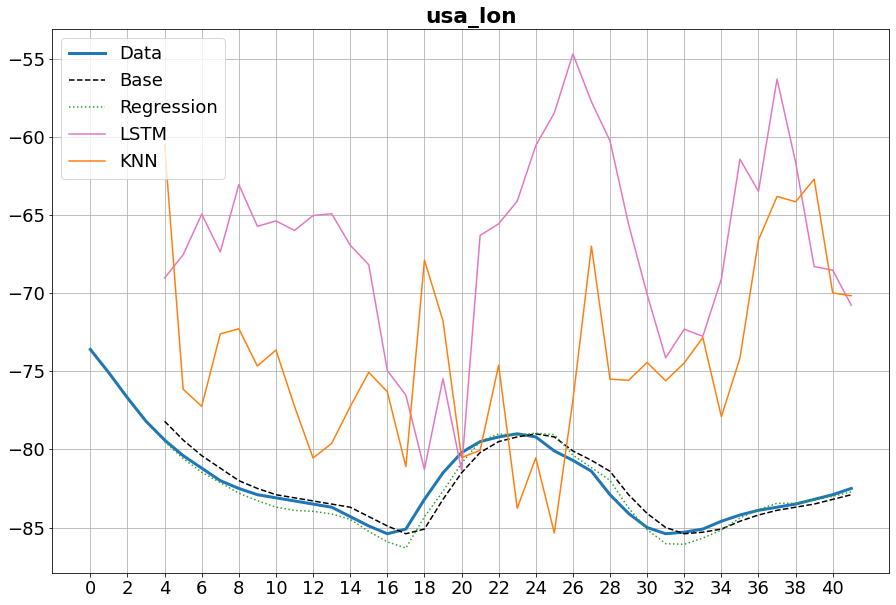

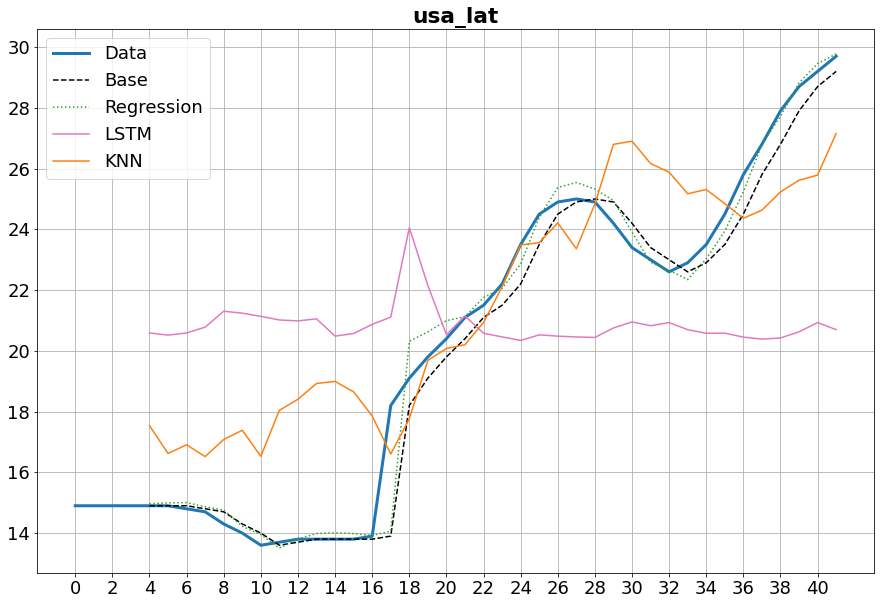

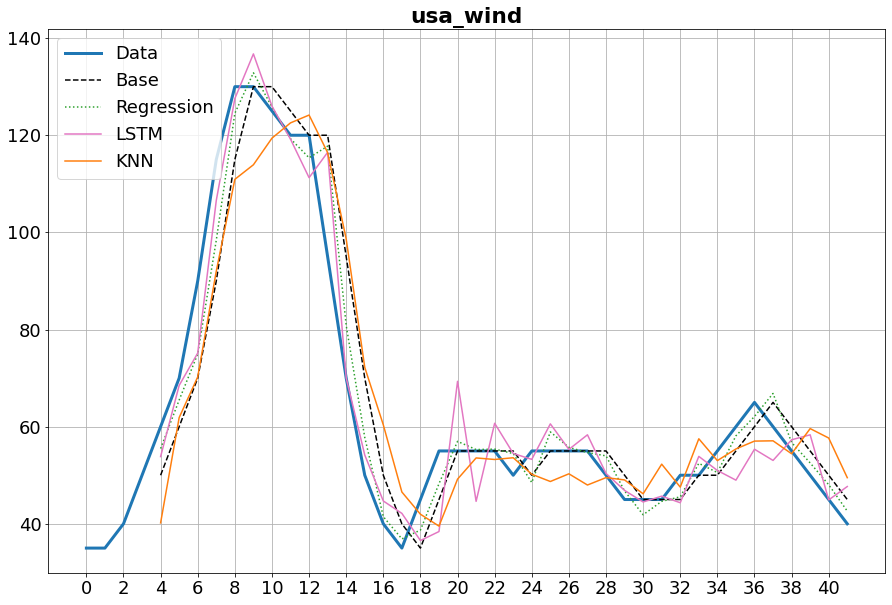

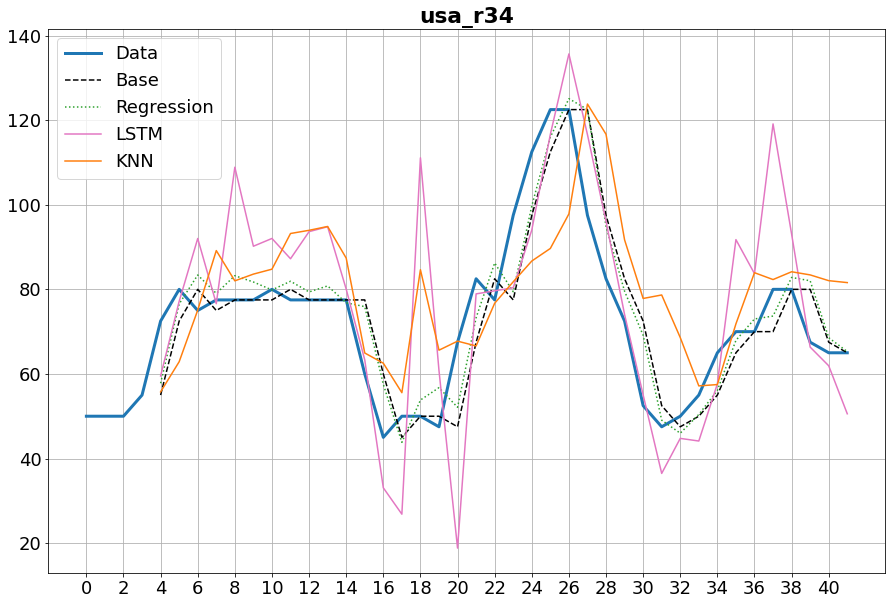

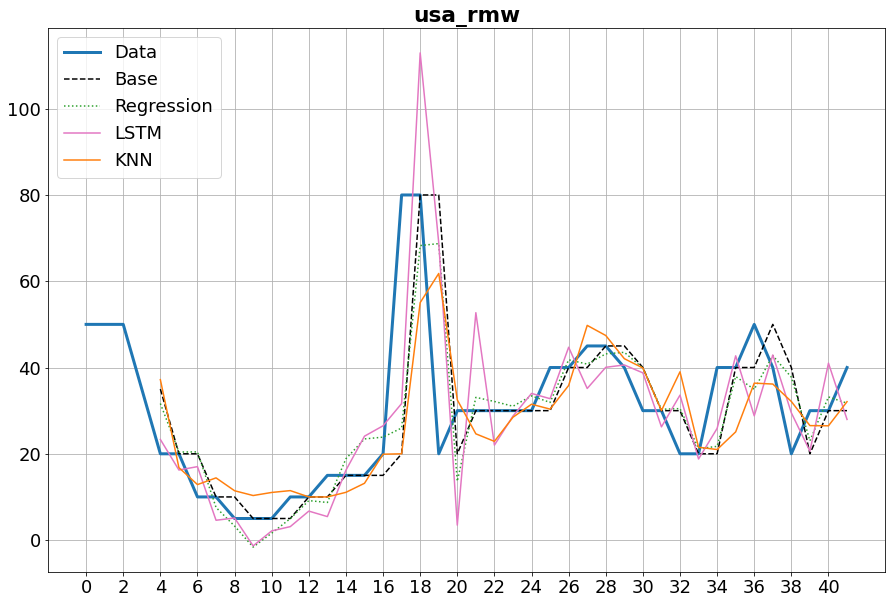

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 125.60it/s]

Storm name:  b'THETA'
Storm ID:  b'2020314N28313'


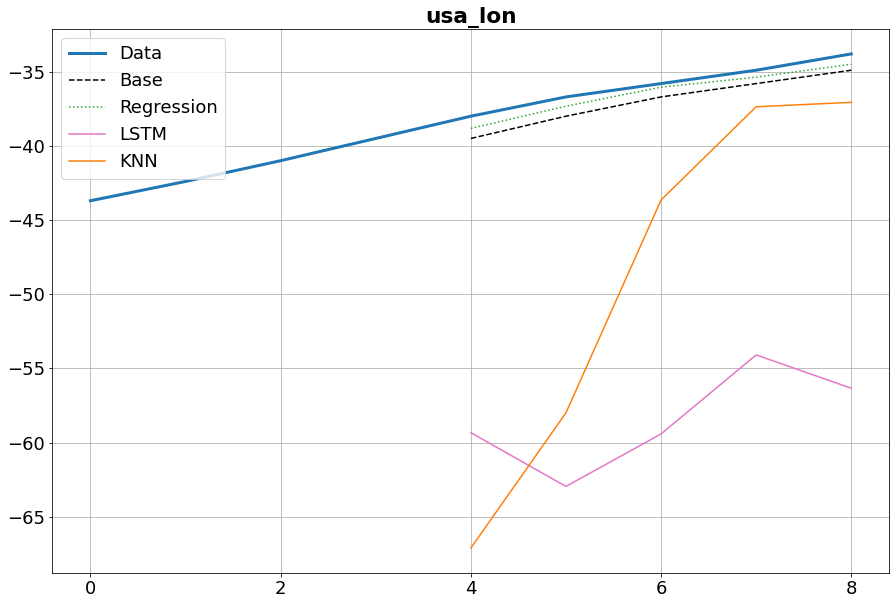

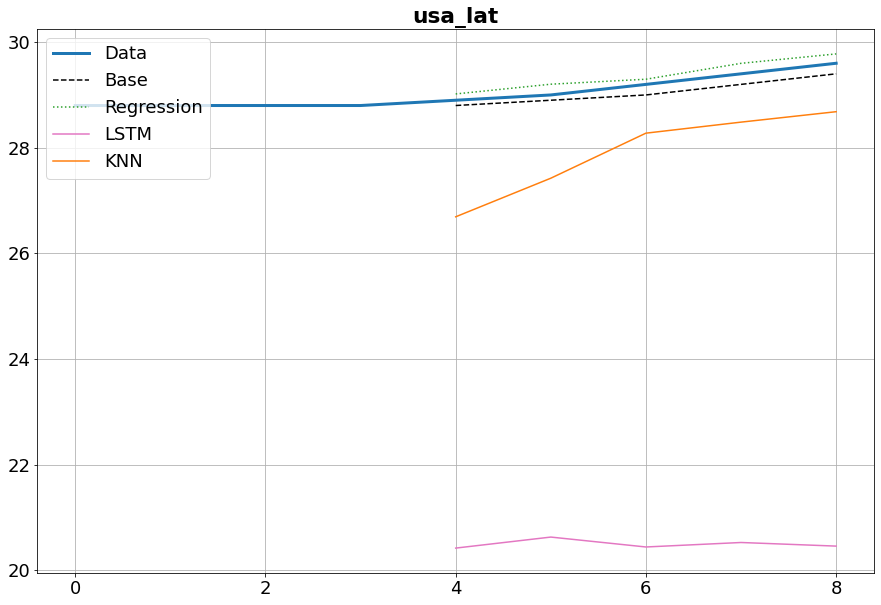

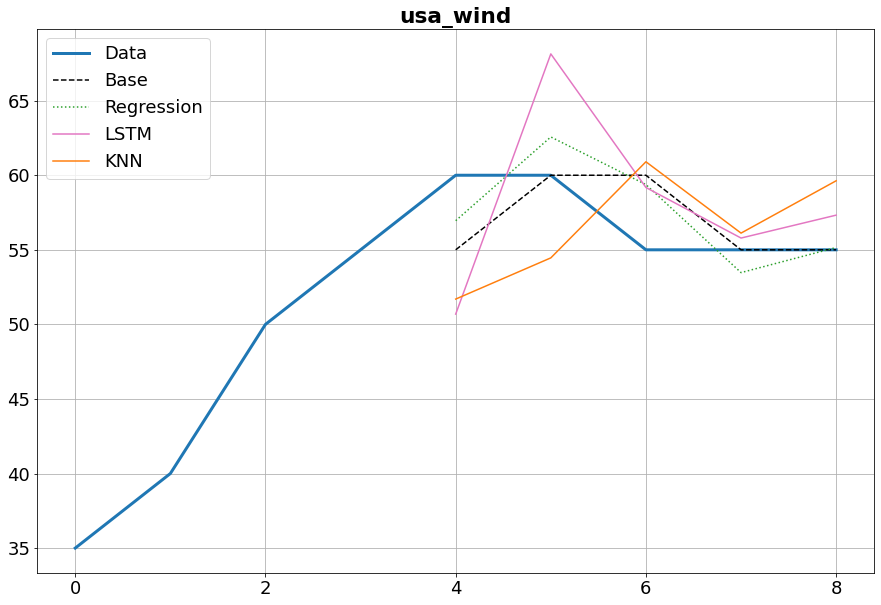

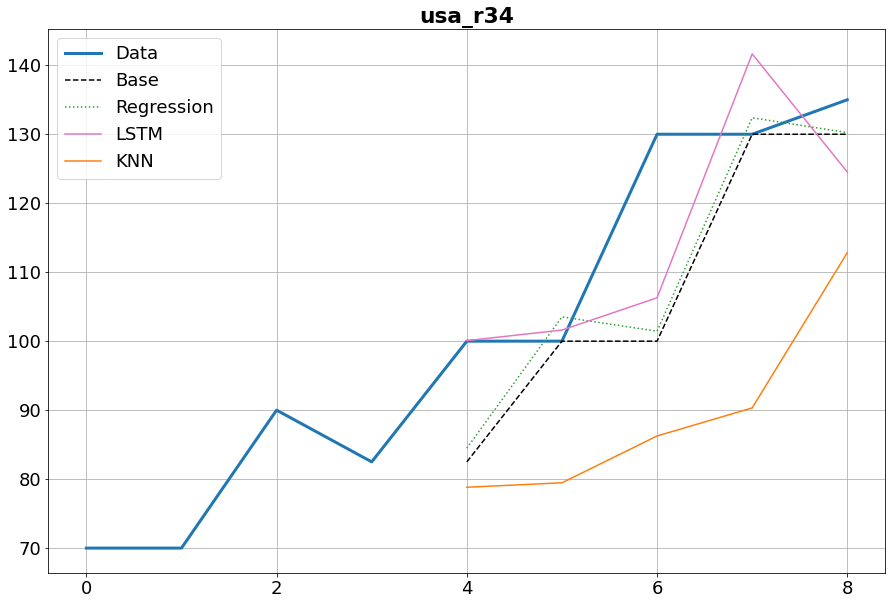

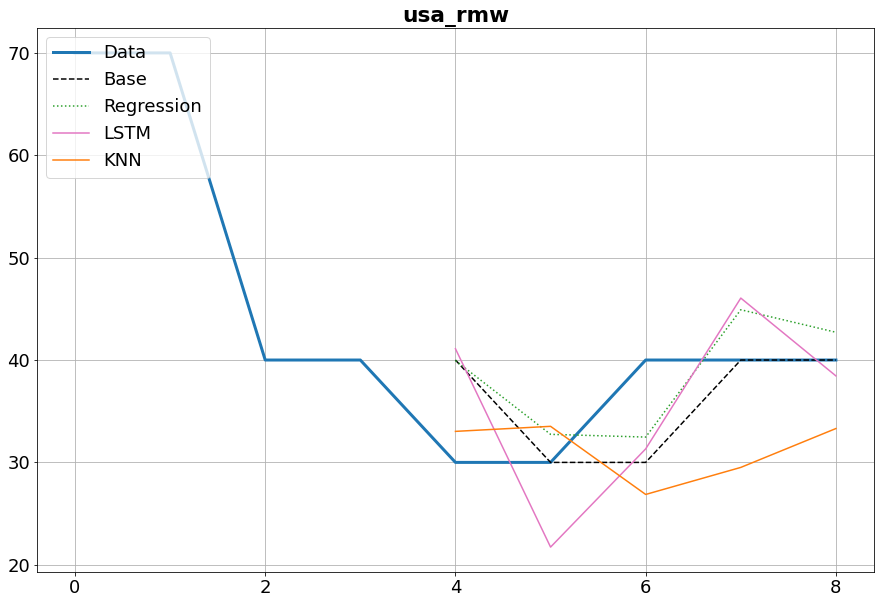

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 46.79it/s]

Storm name:  b'IOTA'
Storm ID:  b'2020318N16289'


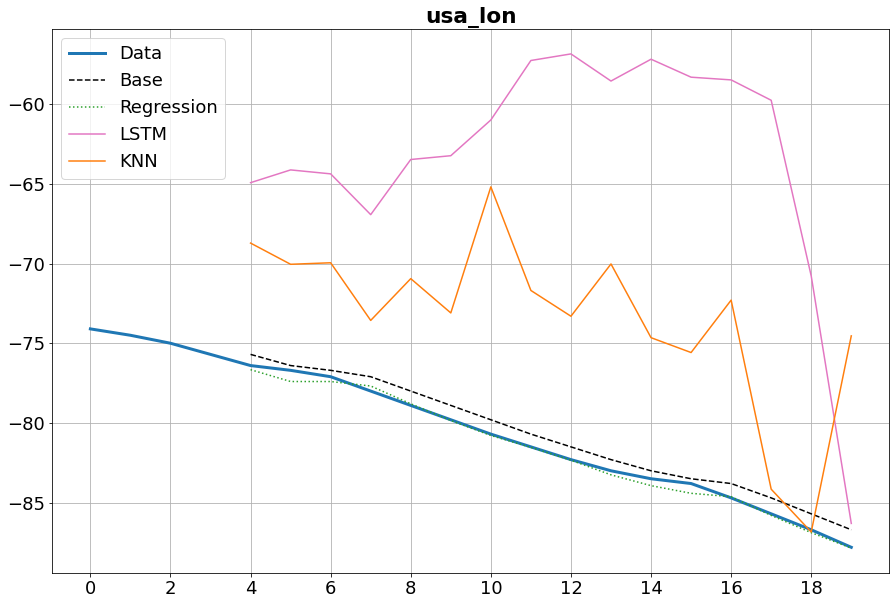

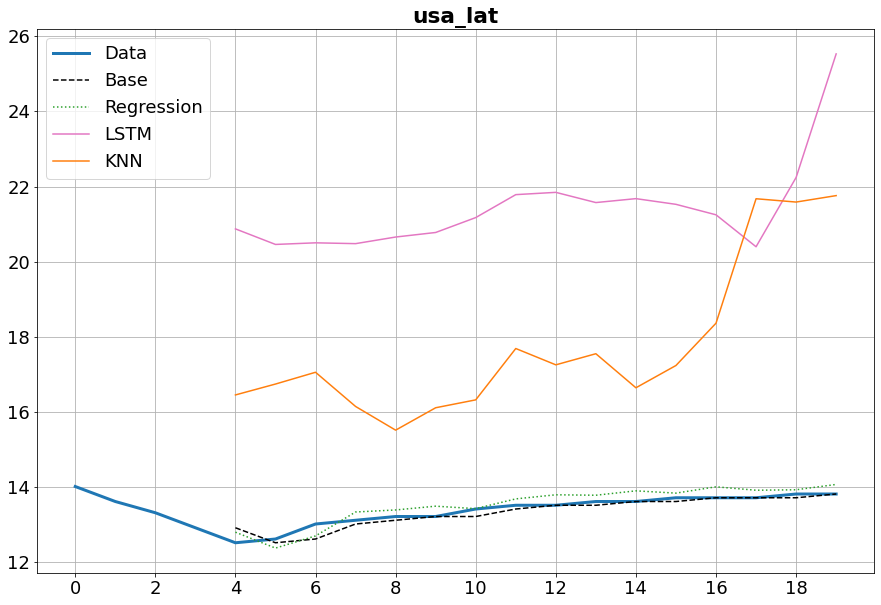

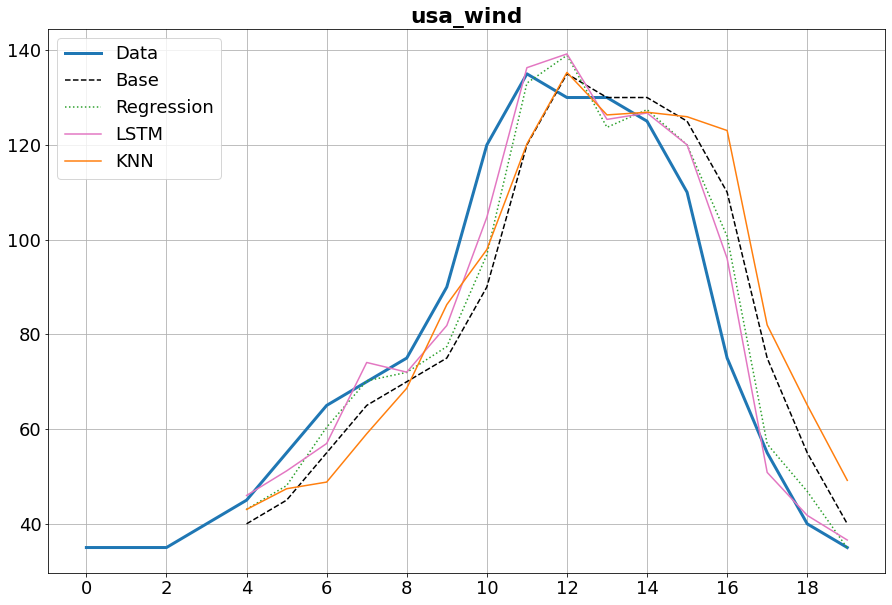

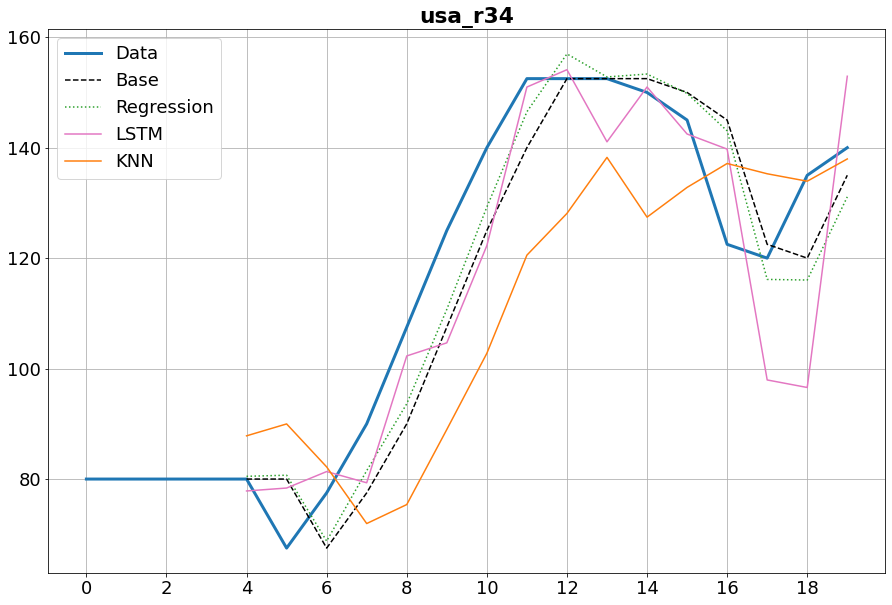

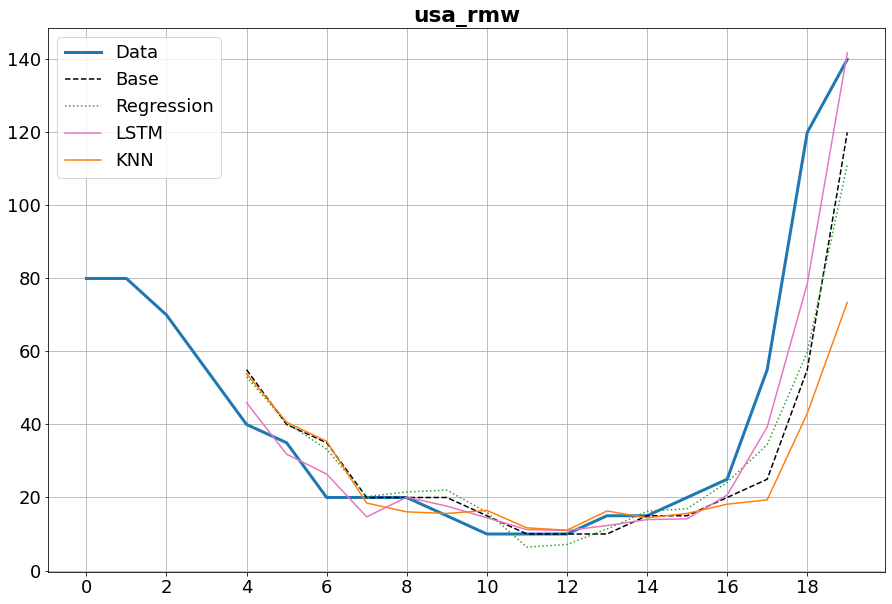

In [11]:
### INFERENCE ON ILLUSTRATIVE CASES
# Select storm
s  = 0 # 75, 80, 120, 130
# -18 to -16 for .ALL dataset

for s in range(-3, 0):
    # LSTM inference
    if s + 1 != 0:
        X_im, y_im = du.create_dataset(ds_test.isel(storm=slice(s, s + 1)),  params_of_interest, PARAMS)
    else: 
        X_im, y_im = du.create_dataset(ds_test.isel(storm=slice(s, None)),  params_of_interest, PARAMS)
    y_im               = np.array(y_im)
    X_im_tensors       = Variable(torch.Tensor(X_im))
    X_im_tensors_final = torch.reshape(X_im_tensors, (X_im_tensors.shape[0], 1, X_im_tensors.shape[1]))
    with torch.no_grad():
        lstm_preds         = lstm1(X_im_tensors_final).cpu().detach().numpy()
    
    # Get full sample (and not only truncated start)
    ds    = ds_test.isel(storm=s)
    # Get only valid stime steps
    ds    = ds[params_of_interest].mean(dim='quadrant', skipna=True)
    ds    = ds.dropna(dim='date_time', subset=params_of_interest)
    xaxis = np.arange(len(ds.date_time))
    print('Storm name: ', str(ds_test.isel(storm=s)['name'][0][0].values))
    print('Storm ID: ', str(ds_test.isel(storm=s)['sid'][0][0].values))
    
    for i, param in enumerate(params_of_interest):
        # Inverse-transform predictions
        data      = du.inverse_scale_normalize(ds[params_of_interest[i]], MU, SIG, SCALE, param)
        base      = data[PARAMS['seq_len'] - 1:-1]
        shift_ax  = (xaxis + 1)[PARAMS['seq_len'] - 1:-1]
        lrg_pred  = du.inverse_scale_normalize(lrg.predict(X_im)[:, i],   MU, SIG, SCALE, param)
        lstm_pred = du.inverse_scale_normalize(lstm_preds[:, i],          MU, SIG, SCALE, param)
        knn_pred  = du.inverse_scale_normalize(knn.predict(X_im)[:, i],   MU, SIG, SCALE, param)
        
        # Plot
        plt.title(param, weight='bold')
        # Data
        plt.plot(xaxis,    data,      label='Data',       color='tab:blue',  linewidth=3)
        # Base
        plt.plot(shift_ax, base,      label='Base',       color='k',         linestyle='--')
        # Linear
        plt.plot(shift_ax, lrg_pred,  label='Regression', color='tab:green', linestyle=':')
        # LSTM
        plt.plot(shift_ax, lstm_pred, label='LSTM',       color='tab:pink')
        # KNN
        plt.plot(shift_ax, knn_pred,  label='KNN',        color='tab:orange')
        
        plt.legend(loc='upper left');plt.grid()
        plt.xticks(xaxis[::2])
        plt.show()


In [12]:
### Compute RMSEs
# Analog forecasting (k-means then average)